<a href="https://colab.research.google.com/github/swishswish123/endosim_demo/blob/main/notebooks/automatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!git clone https://github.com/swishswish123/endosim_demo.git

fatal: destination path 'endosim_demo' already exists and is not an empty directory.


In [45]:
!pip install scikit-surgeryvtk

# Vision-based simulation

In this simulation we explore the errors associated with the approach to go directly from the patient coordinates to the MRI coordinates

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image
import csv



## Utility functions and imports

In [47]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)

In [48]:
from endosim_demo.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist, convert_points_nx3_to_1xnx3


## System layout

The following diagram shows the layout of the navigation system.

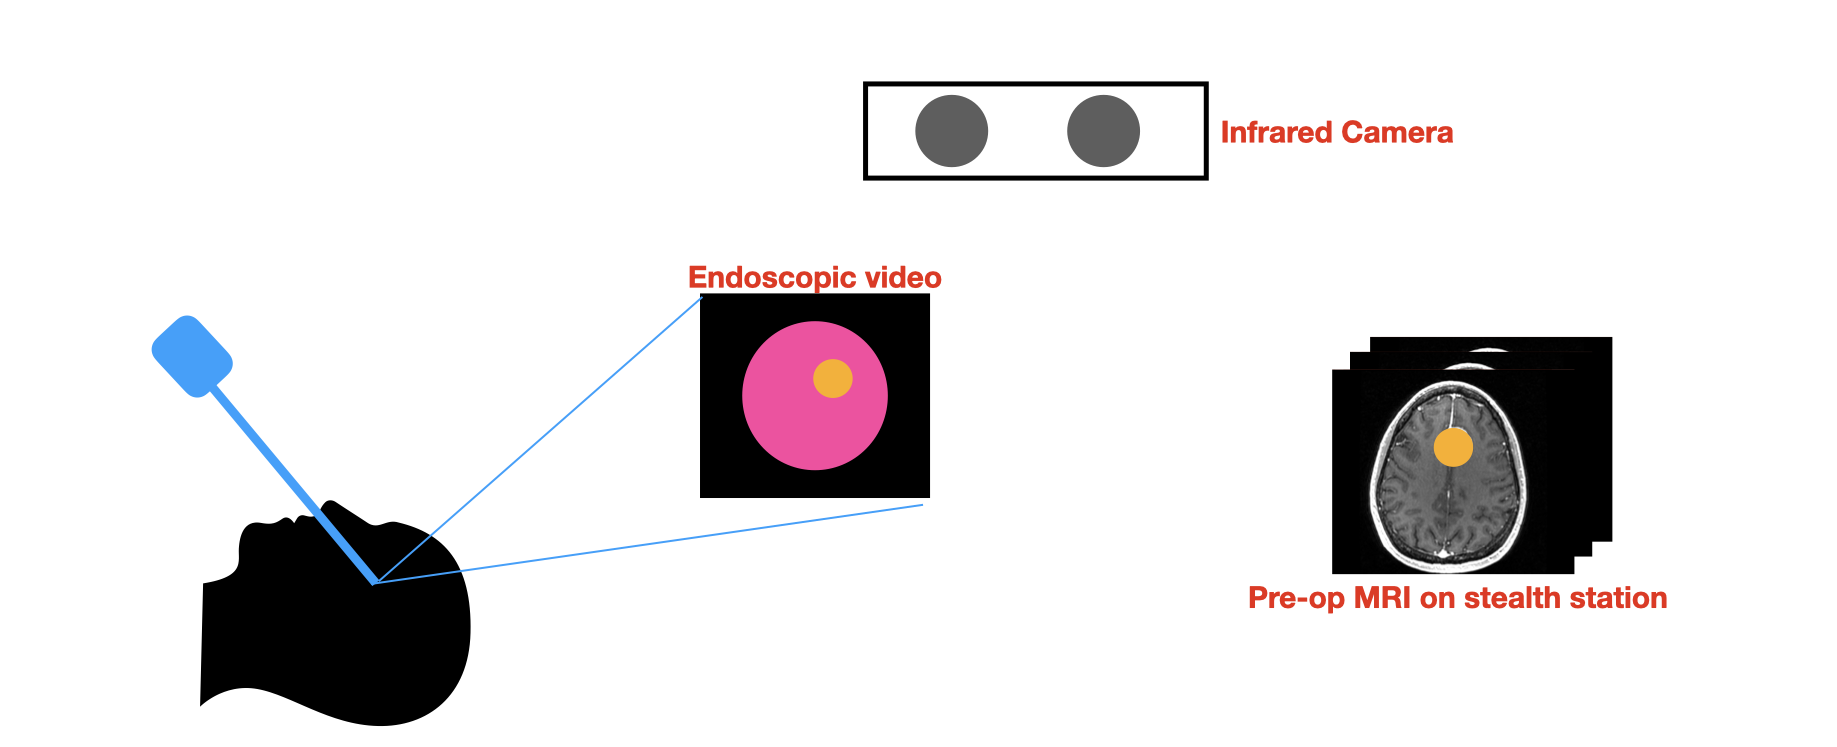

In [49]:
Image(filename="endosim_demo/images/automatic_setup.png")

In the above image, we can see the general setup involved in the surgery when using no tracking and only a vision-based approach. 

The goal, similarly to the endoscope simulation, is to be able to display some segmented piece of information from the pre-operative MRI in MRI coordinates onto the endoscopic video:

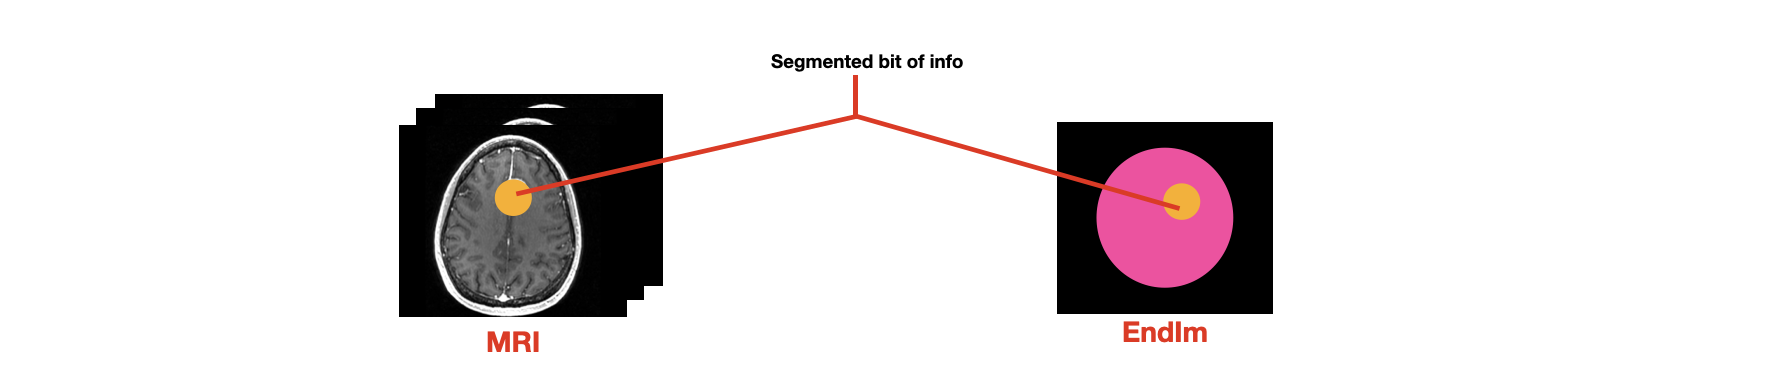

In [50]:
Image(filename="endosim_demo/images/automatic_goal.png")

The goal is therefore turning some segmented MRI coordinates to Endoscopic Image (EndIm) coordinates.

X<sub>EndIm</sub> = <sup>EndIm</sup>T<sub>MRI</sub>  X<sub>MRI</sub>

Below is an visual representation of the vision-based setup with all the transforms:

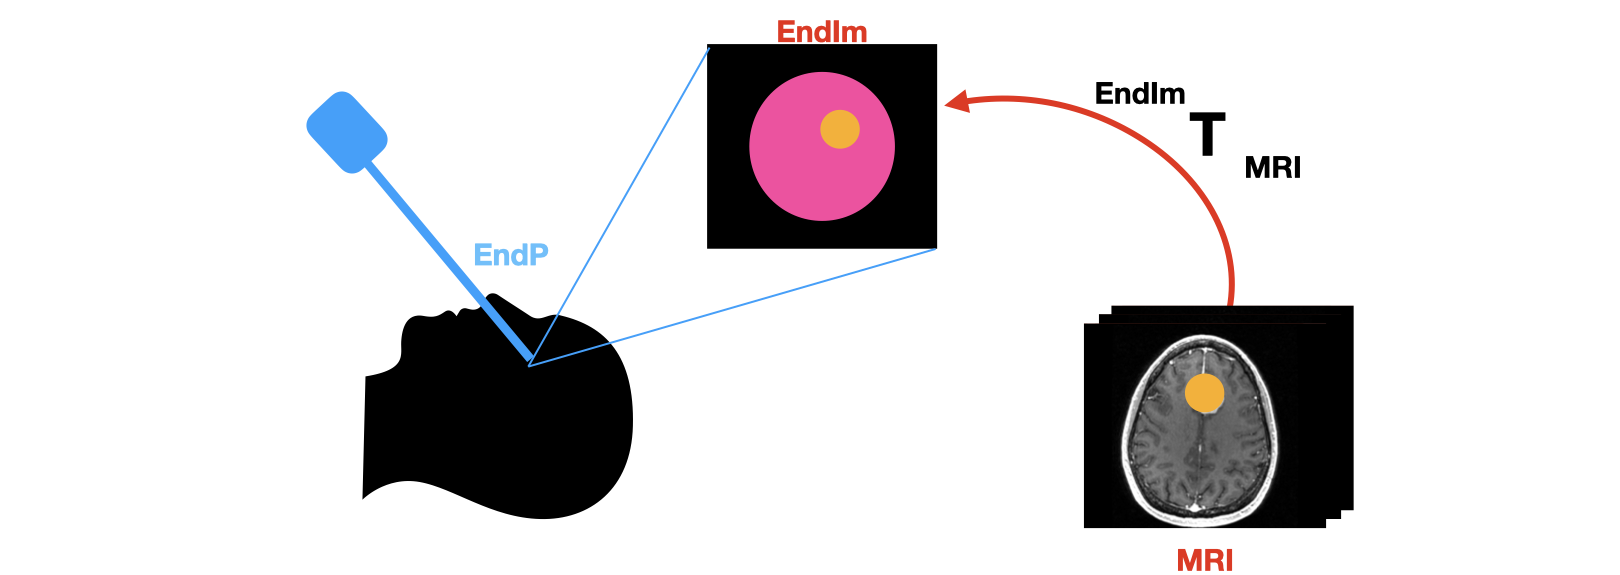

In [51]:
Image(filename="endosim_demo/images/automatic_setup_transforms.png")

# Configurable parameters

If you would like the simulations to go quicker, you can reduce this number but bear in mind the results might be more noisy.

In [52]:
number_samples = 1000

# Generating points for registration

We first create a set of 4 points to represent 4 points of the patient's head.

In [53]:
# creating 4 points in patient coordinates

z = 200 # head length (about 20cm)
x = 250 # menton to top of head (about 25cm)
y = 150 # head bredth (about 15cm)

points = np.array(
[
    [-x,-y,z],
    [-x,y,z],
    [x,y,z],
    [x,-y,z],
])


tumour_point = convert_points_nx3_to_1xnx3(np.array([[0,0,0]]))

points_converted = convert_points_nx3_to_1xnx3(points)


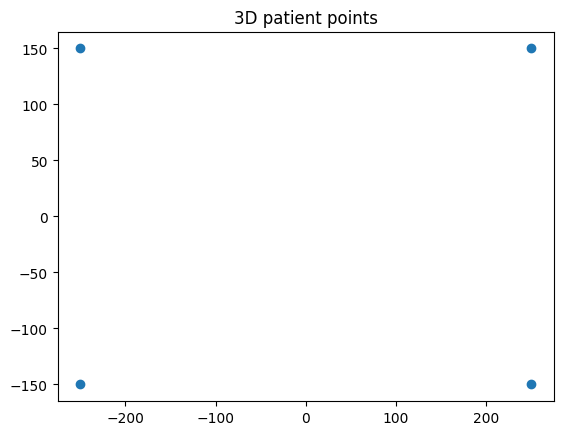

In [54]:
plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.title('3D patient points')
plt.show()

## projecting points from 3D to 2D

We create now the image version of these 3D points by projecting them to 2D.

We use the intrinsics and distortion matrices we got when calibrating the endoscope.

In [55]:
intrinsics = np.loadtxt('endosim_demo/calibration/intrinsics.txt')
distortion = np.loadtxt('endosim_demo/calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))


Intrinsics are:[[664.633   0.    931.532]
 [  0.    663.832 520.64 ]
 [  0.      0.      1.   ]]
Distortion coefficients are:[-4.093e-01  2.163e-01  1.112e-05  1.271e-03 -7.206e-02]


In [56]:

def project_points(points_converted,rvec, tvec, intrinsics, distortion):

    image_points, jacobian = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
    # removing extra empty dimension
    image_points = image_points.squeeze()

    return image_points, jacobian


In [57]:
def solve_pnp(points, image_points, intrinsics, distortion):
    success, R, T = cv2.solvePnP(points.astype('float32'),image_points.astype('float32'),intrinsics, distortion, flags=0)
    R, T = R.T, T.T
    return success, R, T

In [58]:
# converting to format accepted by projectPoints function
#points_converted = convert_points_nx3_to_1xnx3(points)
# projecting the 3D points to 2D.
rvec = np.zeros((1,3))
tvec = np.zeros((1,3))
image_points, _ = project_points(points_converted, rvec, tvec, intrinsics, distortion)
print(image_points)

[[ 590.706  315.331]
 [ 590.678  725.997]
 [1281.256  729.162]
 [1281.228  312.166]]


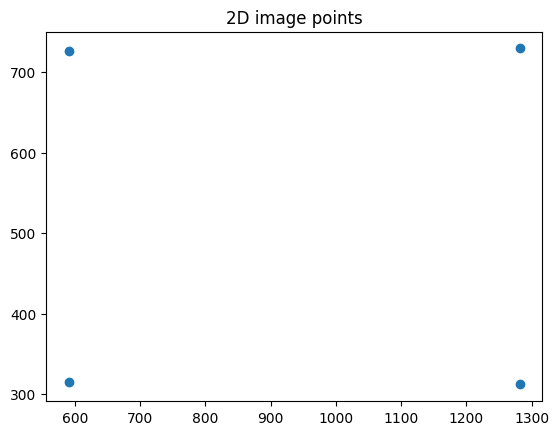

In [59]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.title('2D image points')
plt.show()

# Simulation 1: adding noise to image points (2D)

In this simulation we test the outcome of adding noise to the 2D image points for different values of sigma.

In [60]:
# points-3D
# image_points-2D
# image_points_noisy-2D noisy

First we add noise to the image points (that is- add noise in 2D)

In [61]:
sigma=0.25
image_points_noisy = add_noise_to_points(image_points,sigma)

We then find the corresponding transformation to match the 2D image points to the corresponding 3D locations

In [62]:
# finding transform to get us from 2D image points to 3D object
success_true, rotation_vector_true, translation_vector_true = solve_pnp(points, image_points, intrinsics, distortion)
# finding transform to get us from NOISY 2D image points to 3D object
success, rotation_vector_n, translation_vector_n = solve_pnp(points, image_points_noisy, intrinsics, distortion)

if success_true:
    print(f'rotation true:, {rotation_vector_true}')
    print(f'translation true:, {translation_vector_true}')
else:
    print('solution not found')

if success:
    print(f'rotation noisy:, {rotation_vector_n}')
    print(f'translation noisy:, {translation_vector_n}')
else:
    print('solution not found')


rotation true:, [[-1.338e-04  1.530e-02  2.275e-07]]
translation true:, [[-2.083e+00 -1.823e-02  2.012e+02]]
rotation noisy:, [[0.001 0.017 0.   ]]
translation noisy:, [[ -2.525   0.29  201.326]]


Finally we project the 3D points to 2D with the true and noisy rotation and translation

In [63]:
point_projected2D_true, _ = project_points(points_converted, rotation_vector_true, translation_vector_true, intrinsics, distortion)
print(f'true projected points: {point_projected2D_true}')

point_projected2D_n, _ = project_points(points_converted, rotation_vector_n, translation_vector_n, intrinsics, distortion)
print(f'noisy projected points: {point_projected2D_n}')

true projected points: [[ 590.711  315.322]
 [ 590.683  726.006]
 [1281.251  729.17 ]
 [1281.223  312.158]]
noisy projected points: [[ 590.731  315.514]
 [ 590.901  725.787]
 [1281.039  729.332]
 [1281.295  312.117]]


We can also use this rotation and translation to transform any other point in this coordinate system- eg. a point where the caner is locaed


In [64]:
tumour_projected2D_true, _ = project_points(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
print(f'true projected tumour location{tumour_projected2D_true}')

tumour_projected2D_n, _ = project_points(tumour_point, rotation_vector_n, translation_vector_n, intrinsics, distortion)
print(f'noisy projected tumour location: {tumour_projected2D_n}')


true projected tumour location[924.65 520.58]
noisy projected tumour location: [923.196 521.596]


We can visualise what this 2D error looks like by plotting the noisy and regular points:

In [65]:
print(point_projected2D_n)

[[ 590.731  315.514]
 [ 590.901  725.787]
 [1281.039  729.332]
 [1281.295  312.117]]


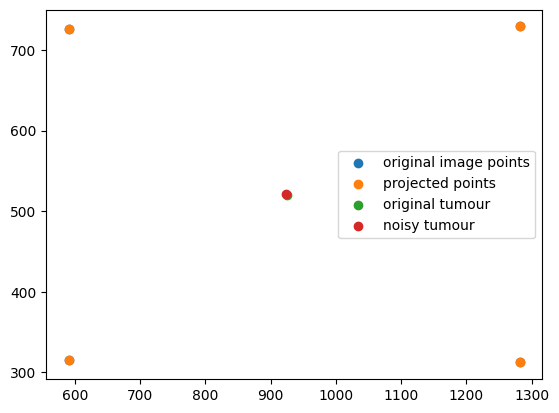

In [66]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(point_projected2D_true[:,0], point_projected2D_true[:,1])

plt.scatter(tumour_projected2D_true[0], tumour_projected2D_true[1])
plt.scatter(tumour_projected2D_n[0], tumour_projected2D_n[1])

plt.legend(['original image points', 'projected points', 'original tumour', 'noisy tumour'])

plt.show()

# Error in 3D

In [67]:

def reverse_projection_pnts(List2D,t, R, K, d=570):
    # List2D : n x 2 array of pixel locations in an image
    # K : Intrinsic matrix for camera
    # R : Rotation matrix describing rotation of camera frame
    #     w.r.t world frame.
    # t : translation vector describing the translation of camera frame
    #     w.r.t world frame
    # [R t] combined is known as the Camera Pose.
    # List2D = np.array(List2D)
    R,_ = cv2.Rodrigues(R)
    List3D = []
    # t.shape = (3,1)

    if len(List2D.shape)==1:
        List2D = np.array([List2D])

    for p in List2D:
        # Homogeneous pixel coordinate
        p = np.array([p[0], p[1], 1]).T; p.shape = (3,1)
        #print("pixel: \n", p)

        # Transform pixel in Camera coordinate frame
        p_cam = np.linalg.inv(K) @ p
        #print("point in cam coords : \n", p_cam, p_cam.shape)

        # Transform pixel in World coordinate frame
        #p_world = t + (R.T@p_cam)
        p_world = (R @ (p_cam-t.T))
        #print("point in world coords : \n", p_world, t.shape, R.shape, p_cam.shape)

        # Transform camera origin in World coordinate frame
        cam = np.array([0,0,0]).T; cam.shape = (3,1)
        #cam_world = t + R @ cam
        cam_world = (R @ (cam-t.T))
        # print("cam_world : \n", cam_world)

        # Find a ray from camera to 3d point
        vector = p_world - cam_world
        unit_vector = vector / np.linalg.norm(vector)
        # print("unit_vector : \n", unit_vector)

        # Point scaled along this ray
        p3D = cam_world + d * unit_vector
        # print("p3D : \n", p3D)
        List3D.append(p3D)

    return np.array(List3D).squeeze()


result_tum: [1.825e+00 1.595e-02 3.688e+02]
result_pnts: [[-244.25  -151.193  291.643]
 [-244.262  151.337  291.587]
 [ 262.137  152.724  280.834]
 [ 262.126 -152.581  280.891]]
result_tum_n: [  0.579   0.888 368.821]
pnts_n: [[-244.253 -151.063  291.681]
 [-244.151  151.206  291.682]
 [ 261.999  152.853  280.868]
 [ 262.164 -152.603  280.863]]


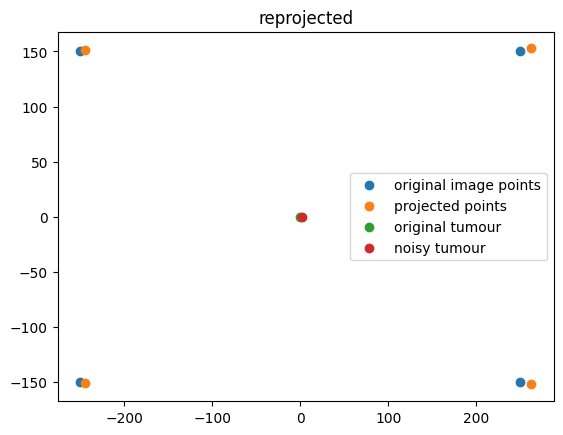

In [68]:
# real
result_tum = reverse_projection_pnts(tumour_projected2D_true, translation_vector_true,rotation_vector_true, intrinsics)
print(f'result_tum: {result_tum}')

result_pnts = reverse_projection_pnts(point_projected2D_true, translation_vector_true,rotation_vector_true, intrinsics)
print(f'result_pnts: {result_pnts}')

# noisy
result_tum_n = reverse_projection_pnts(tumour_projected2D_n, translation_vector_true,rotation_vector_true, intrinsics)
print(f'result_tum_n: {result_tum_n}')

result_pnts_n = reverse_projection_pnts(point_projected2D_n, translation_vector_true,rotation_vector_true, intrinsics)

print(f'pnts_n: {result_pnts_n}')

plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.scatter(result_pnts[:,0], result_pnts[:,1])
#
plt.scatter(tumour_point[:,:,0], tumour_point[:,:,1])
plt.scatter(result_tum[0], result_tum[1])
#
plt.legend(['original image points', 'projected points', 'original tumour', 'noisy tumour'])
plt.title('reprojected')
plt.show()

In [69]:
print(f'tumour 3D true: {tumour_point}')
print(f'tumour 2D true: {tumour_projected2D_true}')
print(f'rotation true:, {rotation_vector_true}')
print(f'translation true:, {translation_vector_true}')

print(f'tumour 2D error: {tumour_projected2D_n}')
print(f'rotation:, {rotation_vector_n}')
print(f'translation:, {translation_vector_n}')


tumour 3D true: [[[0. 0. 0.]]]
tumour 2D true: [924.65 520.58]
rotation true:, [[-1.338e-04  1.530e-02  2.275e-07]]
translation true:, [[-2.083e+00 -1.823e-02  2.012e+02]]
tumour 2D error: [923.196 521.596]
rotation:, [[0.001 0.017 0.   ]]
translation:, [[ -2.525   0.29  201.326]]


Investigating effects of different sigmas

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to (number of samples)
*     add zero mean Gaussian(sigma) noise to each image point
*     match noisy 2D and original 3D points to get transform matrices
*
*     project original 3D points using this noisy transformation
*     measure Euclidean distance in MRI space between noisy image and normal image 2D points
*
*     unproject original and noisy 2D points using this original transformation to get back to 3D
*     measure Euclidean distance in world space between noisy reconstructed and normal reconstructed 3D points    
* 
*   compute RMS error over each iteration and for both mm and pxls
* produce graph of RMS (TRE) for each value of sigma (one for mm and one for pxl)
```

when adding 2D noise, number of pxls off at sigma 0.12 is 0.7581488014927334px or 0.6504589590331163mm


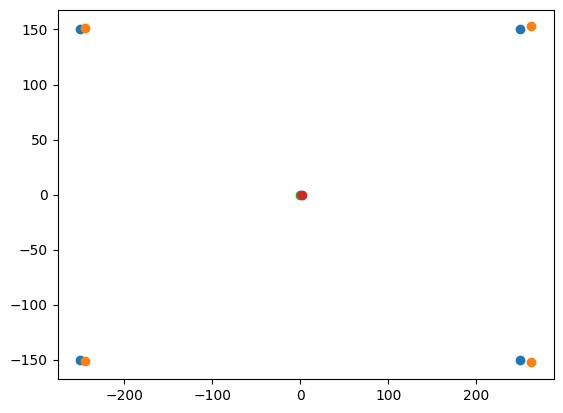

when adding 2D noise, number of pxls off at sigma 0.15 is 0.9483123261787031px or 0.8136366657115733mm


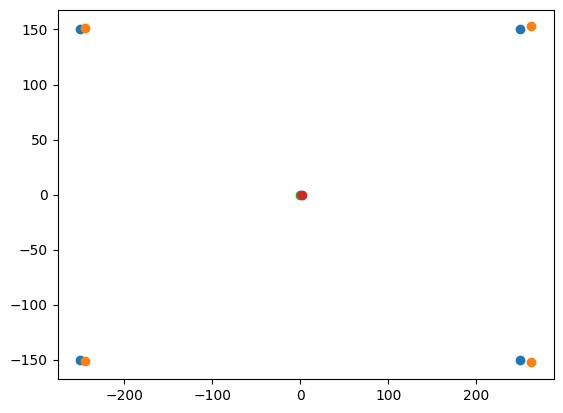

when adding 2D noise, number of pxls off at sigma 0.25 is 1.6244032947410785px or 1.3937043858764149mm


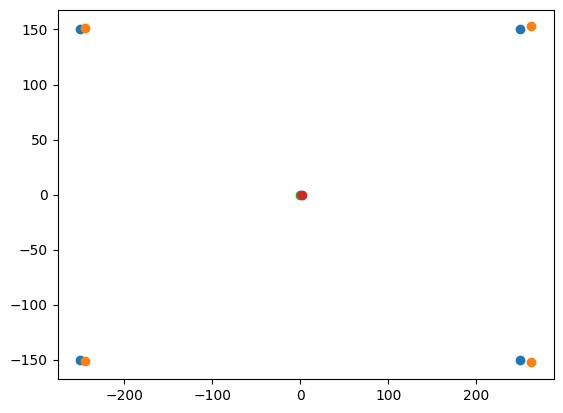

In [70]:

sigmas_1 = []
y_values_px_1 = []
y_values_mm_1 = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms_px = 0
    rms_mm = 0
    for i in range(number_samples):
        
        # add noise to image points
        image_points_noisy = add_noise_to_points(image_points,sigma)
        
        # try and match noisy 2D to original 3d object points
        # true
        success_true, rotation_vector_true, translation_vector_true = solve_pnp(points, image_points, intrinsics,distortion)
        # noisy
        success, rotation_vector_n, translation_vector_n = solve_pnp(points, image_points_noisy, intrinsics,distortion)

        # project tumour 3D point using the found rotations and translations
        # true
        point_projected2D_true, _ = project_points(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        # noisy
        point_projected2D_n, _ = project_points(tumour_point, rotation_vector_n, translation_vector_n, intrinsics, distortion)

        
        euclid_dist_px =  (point_projected2D_true[0] - point_projected2D_n[0]) \
                     * (point_projected2D_true[0] - point_projected2D_n[0]) \
                     + (point_projected2D_true[1] - point_projected2D_n[1]) \
                     * (point_projected2D_true[1] - point_projected2D_n[1])

        # 3D noise
        # reproject tumour
        result_tum = reverse_projection_pnts(point_projected2D_true, translation_vector_true,rotation_vector_true, intrinsics)
        result_tum_n = reverse_projection_pnts(point_projected2D_n, translation_vector_true,rotation_vector_true, intrinsics)



        
        euclid_dist_mm = calculate_euclid_dist(result_tum, result_tum_n)

        rms_px = rms_px + euclid_dist_px
        rms_mm = rms_mm + euclid_dist_mm
        
    rms_px = rms_px / float(number_samples)
    rms_px = np.sqrt(rms_px)

    rms_mm = rms_mm / float(number_samples)
    rms_mm = np.sqrt(rms_mm)
    
    if sigma == 0.25:
        D2_25_px = rms_px
        D2_25_mm = rms_mm
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_25_px}px or {D2_25_mm}mm')

        plt.figure()
        plt.scatter(points[:,0], points[:,1])
        plt.scatter(result_pnts[:,0], result_pnts[:,1])
        #
        plt.scatter(tumour_point[:,:,0], tumour_point[:,:,1])
        plt.scatter(result_tum[0], result_tum[1])
        plt.show()

    if sigma == 0.12:
        D2_12_px = rms_px
        D2_12_mm = rms_mm
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_12_px}px or {D2_12_mm}mm')

        plt.figure()
        plt.scatter(points[:,0], points[:,1])
        plt.scatter(result_pnts[:,0], result_pnts[:,1])
        #
        plt.scatter(tumour_point[:,:,0], tumour_point[:,:,1])
        plt.scatter(result_tum[0], result_tum[1])
        plt.show()

    if sigma == 0.15:
        D2_15_px = rms_px
        D2_15_mm = rms_mm
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_15_px}px or {D2_15_mm}mm')       
        plt.figure()
        plt.scatter(points[:,0], points[:,1])
        plt.scatter(result_pnts[:,0], result_pnts[:,1])
        #
        plt.scatter(tumour_point[:,:,0], tumour_point[:,:,1])
        plt.scatter(result_tum[0], result_tum[1])
        plt.show()

    sigmas_1.append(sigma)
    y_values_px_1.append(rms_px)
    y_values_mm_1.append(rms_mm)



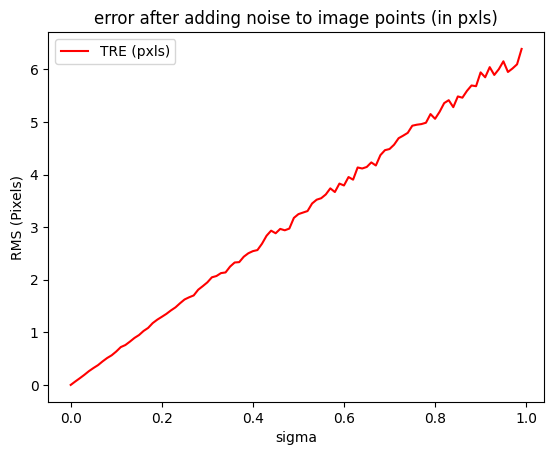

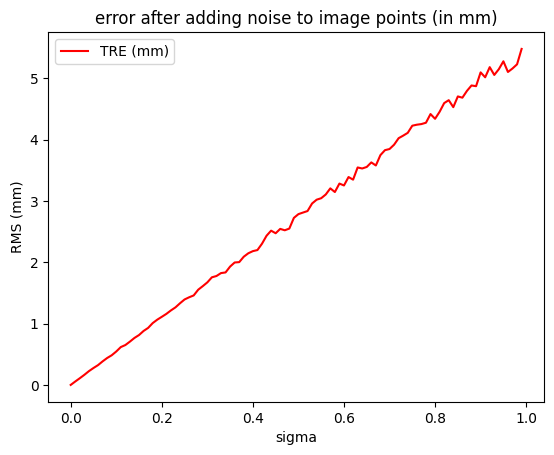

In [71]:
    
plt.plot(sigmas_1, y_values_px_1, 'r', label='TRE (pxls)')
plt.title('error after adding noise to image points (in pxls)')
plt.legend(loc='upper left')
plt.xlabel('sigma')
plt.ylabel('RMS (Pixels)')
plt.show()

plt.plot(sigmas_1, y_values_mm_1, 'r', label='TRE (mm)')
plt.title('error after adding noise to image points (in mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma')
plt.ylabel('RMS (mm)')
plt.show()

## Simulation 2: adding noise to 3D


In this simulation we investigate the effect of adding noise to the 3D points before projecting for different sigma values.

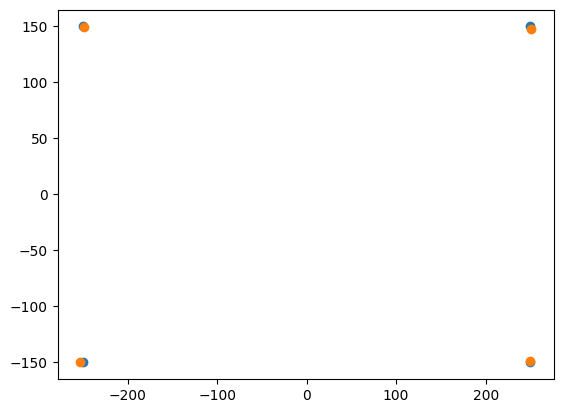

In [72]:
noisy_points = add_noise_to_points(points, 1.5)

plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.scatter(noisy_points[:,0], noisy_points[:,1])
plt.show()


Project both noisy points and real points to 2D

In [73]:
image_points, _ = project_points(points_converted, rvec, tvec, intrinsics, distortion)
image_points_noisy, _ = project_points(noisy_points, rvec, tvec, intrinsics, distortion)

Find transformations to get from 3D to 2D

In [74]:
_, rotation_vector_true, translation_vector_true = solve_pnp(points, image_points, intrinsics, distortion)

_, rotation_vector_n, translation_vector_n = solve_pnp(noisy_points, image_points_noisy, intrinsics, distortion)


Use these transformations to transform a tumour

In [75]:
tumour_projected2D_true, _ = project_points(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
print(tumour_projected2D_true)

tumour_projected2D_n, _ = project_points(tumour_point, rotation_vector_n, translation_vector_n, intrinsics, distortion)
print(tumour_projected2D_n)

[924.65 520.58]
[891.413 454.662]


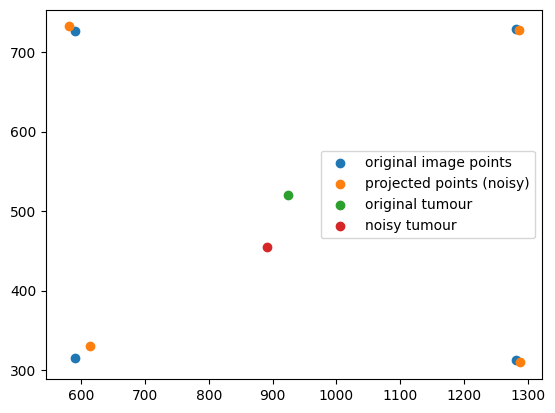

In [76]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])
#plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])


plt.scatter(tumour_projected2D_true[0], tumour_projected2D_true[1])
plt.scatter(tumour_projected2D_n[0], tumour_projected2D_n[1])

plt.legend(['original image points', 'projected points (noisy)', 'original tumour', 'noisy tumour'])

plt.show()

#### and to get noise in mm, we unproject to 3D

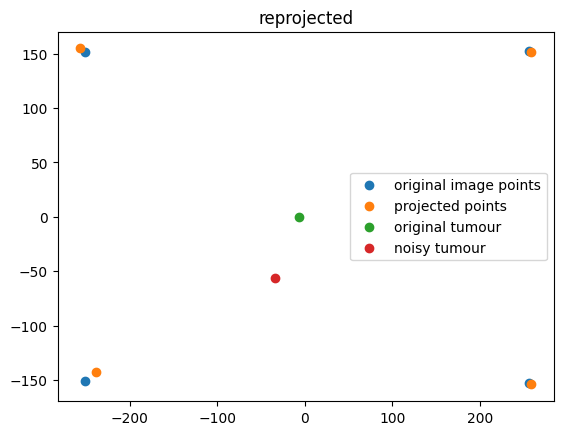

In [77]:
# real
result_tum = reverse_projection_pnts(tumour_projected2D_true, tvec,rvec, intrinsics)
result_pnts = reverse_projection_pnts(image_points, tvec,rvec, intrinsics)

# noisy
result_tum_n = reverse_projection_pnts(tumour_projected2D_n, tvec,rvec, intrinsics)
result_pnts_n = reverse_projection_pnts(image_points_noisy, tvec,rvec, intrinsics)

plt.figure()
plt.scatter(result_pnts[:,0], result_pnts[:,1])
plt.scatter(result_pnts_n[:,0], result_pnts_n[:,1])

plt.scatter(result_tum[0], result_tum[1])
plt.scatter(result_tum_n[0], result_tum_n[1])

plt.legend(['original image points', 'projected points', 'original tumour', 'noisy tumour'])
plt.title('reprojected')
plt.show()

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to (number of samples)
*     add zero mean Gaussian(sigma) noise to each object point (3D)
*     project both noisy and original 3D object points
*     match regular 2D and noisy 3D points to get transform matrices
*     project 3D original tumour location using this noisy transformation
*     measure Euclidean distance in MRI space between projecting the tumour with noisy transform as opposed to non-noisy

*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

In [78]:

sigmas_2 = []
y_values_px_2 = []
y_values_mm_2 = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms_px = 0
    rms_mm = 0
    for i in range(number_samples):
        
        # add noise to 3D points
        noisy_points = add_noise_to_points(points, sigma)
        
        # project both noisy and non-noisy 3D points to 2D
        image_points, _ = project_points(points_converted, rvec, tvec, intrinsics, distortion)
        image_points_noisy, _ = project_points(noisy_points, rvec, tvec, intrinsics, distortion)
        
        # try and match noisy 2D to original 3d object points and get transformation
        # true
        success_true, rotation_vector_true, translation_vector_true = solve_pnp(points, image_points, intrinsics, distortion)
        # noisy
        success, rotation_vector_n, translation_vector_n = solve_pnp(noisy_points, image_points_noisy, intrinsics, distortion)
        
        # project tumour 3D point using the found rotations and translations
        # true
        tumour_projected2D_true, _ = project_points(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        # noisy
        tumour_projected2D_n, _ = project_points(tumour_point, rotation_vector_n, translation_vector_n, intrinsics, distortion)
        
        euclid_dist_px =  (tumour_projected2D_true[0] - tumour_projected2D_n[0]) \
                     * (tumour_projected2D_true[0] - tumour_projected2D_n[0]) \
                     + (tumour_projected2D_true[1] - tumour_projected2D_n[1]) \
                     * (tumour_projected2D_true[1] - tumour_projected2D_n[1])
        
        # 3D noise
        # reproject tumour
        result_tum = reverse_projection_pnts(tumour_projected2D_true,translation_vector_true,rotation_vector_true, intrinsics)
        result_tum_n = reverse_projection_pnts(tumour_projected2D_n, translation_vector_true,rotation_vector_true, intrinsics)
        
        euclid_dist_mm = calculate_euclid_dist(result_tum, result_tum_n)

        #euclid_dist_mm = calculate_euclid_dist()
        
        rms_px = rms_px + euclid_dist_px
        rms_mm = rms_mm + euclid_dist_mm
        
    rms_px = rms_px / float(number_samples)
    rms_px = np.sqrt(rms_px)

    rms_mm = rms_mm / float(number_samples)
    rms_mm = np.sqrt(rms_mm)

    if sigma == 0.25:
        D3_25_px = rms_px
        D3_25_mm = rms_mm
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D3_25_px}px or {D3_25_mm}mm')
    if sigma == 0.12:
        D3_12_px = rms_px
        D3_12_mm = rms_mm
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D3_12_px}px or {D3_12_mm}mm')
    if sigma == 0.15:
        D3_15_px = rms_px
        D3_15_mm = rms_mm
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D3_15_px}px or {D3_15_mm}mm')       

        
    sigmas_2.append(sigma)
    y_values_px_2.append(rms_px)
    y_values_mm_2.append(rms_mm)
    

when adding 2D noise, number of pxls off at sigma 0.12 is 4.536296881506712px or 3.8934314108607264mm
when adding 2D noise, number of pxls off at sigma 0.15 is 5.759836666711326px or 4.94345567162146mm
when adding 2D noise, number of pxls off at sigma 0.25 is 9.495978835981575px or 8.149207379549745mm


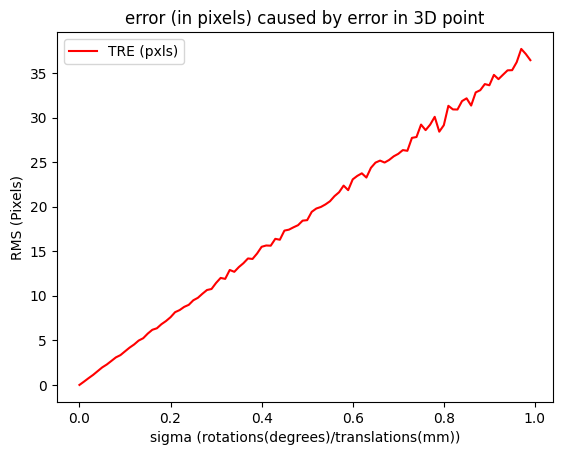

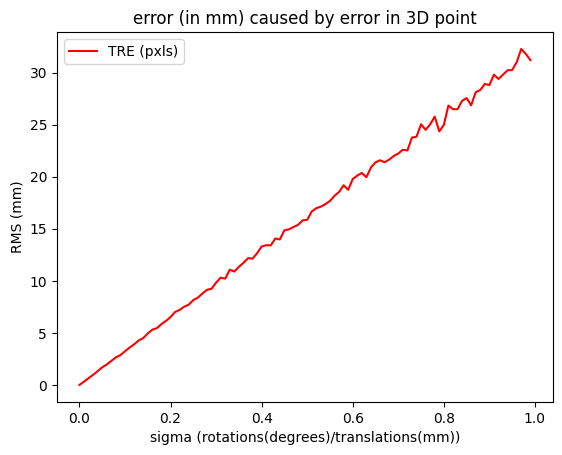

In [79]:
plt.plot(sigmas_2, y_values_px_2, 'r', label='TRE (pxls)')
plt.title('error (in pixels) caused by error in 3D point')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()

plt.plot(sigmas_2, y_values_mm_2, 'r', label='TRE (pxls)')
plt.title('error (in mm) caused by error in 3D point')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (mm)')
plt.show()


## Simulation 3: adding noise to both

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to (number of samples)
*     add zero mean Gaussian(sigma) noise to each object point (3D)
*     project both noisy and original 3D object points to 2D
*     add zero mean Gaussian(sigma) noise to each 2D image point of the noisy projected points
*     match noisy 2D with original 3D points to get transform matrices
*     project tumour 3D location using this noisy transformation
*     measure Euclidean distance in MRI space between projecting the tumour with noisy transform as opposed to non-noisy
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

In [80]:

sigmas_3 = []
y_values_px_3 = []
y_values_mm_3 = []


for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    
    rms_px = 0
    rms_mm = 0
    for i in range(number_samples):
        
        # add noise to 3D points
        noisy_points = add_noise_to_points(points, sigma)
        
        # project both noisy and non-noisy 3D points to 2D
        image_points, _ = project_points(points_converted, rvec, tvec, intrinsics, distortion)
        image_points_noise_3D, _ = project_points(noisy_points, rvec, tvec, intrinsics, distortion)
        #print(image_points_noise_3D)
        # add noise to 2D points
        image_points_noisy = add_noise_to_points(image_points_noise_3D,sigma)
        #print(image_points_noisy)
        
        # try and match noisy 2D to original 3d object points and get transformation
        # true
        success_true, rotation_vector_true, translation_vector_true = solve_pnp(points, image_points, intrinsics, distortion)
        # noisy
        success, rotation_vector_n, translation_vector_n = solve_pnp(points, image_points_noisy, intrinsics, distortion)
        
        # project tumour 3D point using the found rotations and translations
        # true
        tumour_projected2D_true, _ = project_points(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        # noisy
        tumour_projected2D_n, _ = project_points(tumour_point, rotation_vector_n, translation_vector_n, intrinsics, distortion)

        
        euclid_dist_px =  (tumour_projected2D_true[0] - tumour_projected2D_n[0]) \
                     * (tumour_projected2D_true[0] - tumour_projected2D_n[0]) \
                     + (tumour_projected2D_true[1] - tumour_projected2D_n[1]) \
                     * (tumour_projected2D_true[1] - tumour_projected2D_n[1])
        
        
        #euclid_dist_mm = calculate_euclid_dist()

        # 3D noise
        # reproject tumour
        result_tum = reverse_projection_pnts(tumour_projected2D_true, translation_vector_true,rotation_vector_true, intrinsics)
        result_tum_n = reverse_projection_pnts(tumour_projected2D_n, translation_vector_true,rotation_vector_true, intrinsics)
        
        euclid_dist_mm = calculate_euclid_dist(result_tum, result_tum_n)

        #euclid_dist_mm = calculate_euclid_dist()
        
        rms_px = rms_px + euclid_dist_px
        rms_mm = rms_mm + euclid_dist_mm
        
        
        
    rms_px = rms_px / float(number_samples)
    rms_px = np.sqrt(rms_px)

    rms_mm = rms_mm / float(number_samples)
    rms_mm = np.sqrt(rms_mm)

    if sigma == 0.25:
        D3D2_25_px = rms_px
        D3D2_25_mm = rms_mm
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_25_px}px or {D3D2_25_mm}mm')
    if sigma == 0.12:
        D3D2_12_px = rms_px
        D3D2_12_mm = rms_mm
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_12_px}px or {D3D2_12_mm}mm')
    if sigma == 0.15:
        D3D2_15_px = rms_px
        D3D2_15_mm = rms_mm
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_15_px}px or {D3D2_15_mm}mm')       


    sigmas_3.append(sigma)
    y_values_px_3.append(rms_px)
    y_values_mm_3.append(rms_mm)
    
    


when adding 3D noise and 2D noise, number of pxls off at sigma 0.12 is 4.409015166945606px or 3.7841491461268846mm
when adding 3D noise and 2D noise, number of pxls off at sigma 0.15 is 5.31612674367784px or 4.56253213473454mm
when adding 3D noise and 2D noise, number of pxls off at sigma 0.25 is 8.763045904656446px or 7.520120918225108mm


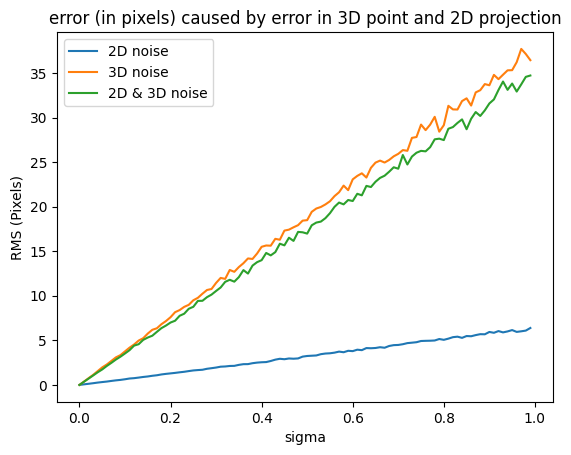

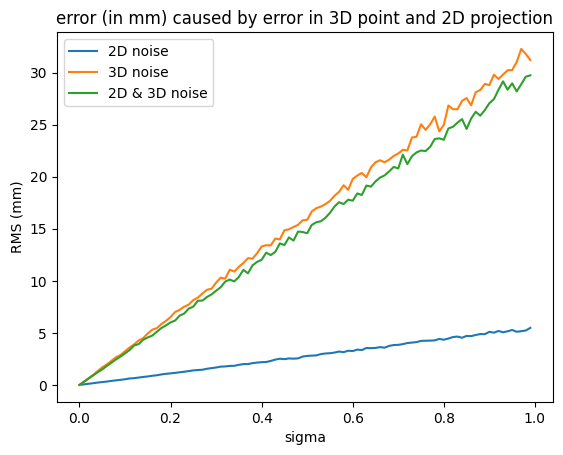

In [81]:
plt.plot(sigmas_1, y_values_px_1, label='2D noise')
plt.plot(sigmas_2, y_values_px_2, label='3D noise')
plt.plot(sigmas_3, y_values_px_3, label='2D & 3D noise')

plt.title('error (in pixels) caused by error in 3D point and 2D projection')
plt.legend(loc='upper left')
plt.xlabel('sigma')
plt.ylabel('RMS (Pixels)')
plt.show()

plt.plot(sigmas_1, y_values_mm_1, label='2D noise')
plt.plot(sigmas_2, y_values_mm_2, label='3D noise')
plt.plot(sigmas_3, y_values_mm_3, label='2D & 3D noise')

plt.title('error (in mm) caused by error in 3D point and 2D projection')
plt.legend(loc='upper left')
plt.xlabel('sigma')
plt.ylabel('RMS (mm)')
plt.show()

# Summary and Results of vision-based simulation

In [82]:
np.set_printoptions(precision=3)

### Only 2D noise

The following are the results of adding noise in 2D:

In [83]:
print(f'sigma 0.12: {D2_12_px}px, {D2_12_mm}mm')
print(f'sigma 0.15: {D2_15_px}px, {D2_15_mm}mm')
print(f'sigma 0.25: {D2_25_px}px, {D2_25_mm}mm')

sigma 0.12: 0.7581488014927334px, 0.6504589590331163mm
sigma 0.15: 0.9483123261787031px, 0.8136366657115733mm
sigma 0.25: 1.6244032947410785px, 1.3937043858764149mm


### Only 3D noise

Adding noise to only 3D object points

In [84]:
print(f'sigma 0.12: {D3_12_px}px, {D3_12_mm}mm')
print(f'sigma 0.15: {D3_15_px}px, {D3_15_mm}mm')
print(f'sigma 0.25: {D3_25_px}px, {D3_25_mm}mm')

sigma 0.12: 4.536296881506712px, 3.8934314108607264mm
sigma 0.15: 5.759836666711326px, 4.94345567162146mm
sigma 0.25: 9.495978835981575px, 8.149207379549745mm


### Both 2D and 3D noise

Adding noise in both endoscope image and object 

In [86]:
print(f'sigma 0.12: {D3D2_12_px}px, {D3D2_12_mm}mm')
print(f'sigma 0.15: {D3D2_15_px}px, {D3D2_15_mm}mm')
print(f'sigma 0.25: {D3D2_25_px}px, {D3D2_25_mm}mm')

sigma 0.12: 4.409015166945606px, 3.7841491461268846mm
sigma 0.15: 5.31612674367784px, 4.56253213473454mm
sigma 0.25: 8.763045904656446px, 7.520120918225108mm


In [91]:


header = ['error', 'sigma_12', 'sigma_15', 'sigma_25']

data_automatic_px = [
    ['D2_errors_px', D2_12_px, D2_15_px, D2_25_px],
    ['D2_errors_mm', D2_12_mm, D2_15_mm, D2_25_mm],
    ['D3_errors_px', D3_25_px, D3_15_px, D3_25_px],
    ['D3_errors_mm', D3_25_mm, D3_15_mm, D3_25_mm],
    ['D3D2_errors_px', D3D2_12_px, D3D2_15_px, D3D2_25_px],
    ['D3D2_errors_mm', D3D2_12_mm, D3D2_15_mm, D3D2_25_mm]
]

data_automatic_mm = [
    ['D2_errors_px', D2_12_px, D2_15_px, D2_25_px],
    ['D2_errors_mm', D2_12_mm, D2_15_mm, D2_25_mm],
    ['D3_errors_px', D3_25_px, D3_15_px, D3_25_px],
    ['D3_errors_mm', D3_25_mm, D3_15_mm, D3_25_mm],
    ['D3D2_errors_px', D3D2_12_px, D3D2_15_px, D3D2_25_px],
    ['D3D2_errors_mm', D3D2_12_mm, D3D2_15_mm, D3D2_25_mm]
]

with open('results/automatic.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    # Use writerows() not writerow()
    writer.writerows(data_automatic)